In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
cwd = os.getcwd().replace("/note/experiments", "")
os.chdir(cwd)


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import xtools as xt
import json
import xsim
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm
from collections import namedtuple


In [4]:
from qml.db import dpo as xdpo
from qml.db import target as xtarget
from qml.db.ml import MLDatasetGenerator
from qml.db.dpo.decoder import DPODataDecoder, DPOData
from qml.db.dpo.loader import DPODataBatch
from qml.model.gate import Gateset
from qml.model.unit import UnitManager, Unit
from qml.model.encoding import EncodingUnitManager
from qml.model.model import Model
from qml.optimizer import dpo as xdpopt
from qml.optimizer import evaluator as xeval
from qml.tools.random import XRandomGenerator
from qml.tools.sampler import CandidateSampler
from qml import optimizer as xoptim
from qml.tools.config import Config
# from qml.tools.validation import validate
from qml.tools.validation import get_base_qc
from qml.tools.experiment_tools import train_once, hard_copy, prepare_policy, plot_results, validate, generate_batch, soft_update

In [6]:
def plot_results_on_notebook(logger, vlogger, cf):
    ret = xsim.Retriever(logger)
    res_dict = dict(
        step=ret.step(),
        loss=ret.loss(),
        loss_dpo=ret.loss_dpo(),
    )
    plot_labels = ["loss_dpo"]
    if cf.dpo.training.cpo:
        res_dict["loss_llh"] = ret.loss_llh()
        plot_labels.append("loss_llh")
    plot_labels.append("loss")
    res = pd.DataFrame(res_dict)

    # vret = xsim.Retriever(vlogger)
    # vres = pd.DataFrame(dict(
    #     epoch=vret.epoch(),
    #     loss=vret.loss(),
    #     time=vret.time(),
    # ))

    clear_output()
    fig, axes = plt.subplots(nrows=1)  #, figsize=(8, 10), sharex=True)
    # fig, axes = plt.subplots(nrows=3, figsize=(8, 10), sharex=True)
    res.plot(x="step", y=plot_labels, ax=axes)
    # vres.plot(x="epoch", y=["loss"], ax=axes[1])
    # vres.plot(x="epoch", y=["time"], ax=axes[2])
    plt.show()

    return res
    # return res, vres


# mian loop

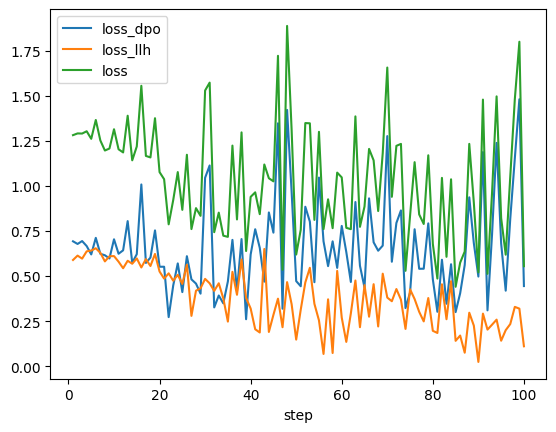

In [7]:
# save_dir = xt.make_dirs_current_time("note/experiments/results")
save_dir = 'note/experiments/results/2025.04.11.081434'

cf = Config("note/experiments/config.yaml")

# rng
rng = XRandomGenerator(0)
np.random.seed(rng.seed)
torch.manual_seed(rng.new_seed())

# build policies
policy, reference, optimizer, sampler = prepare_policy(cf)
logger = xsim.Logger()
vlogger = xsim.Logger()
dlogger = xsim.Logger()

gset = Gateset.set_num_qubits(cf.nq)


for step in range(1, 101):
    # soft_update(policy, reference, 0.05)
    batch = generate_batch(sampler, cf)
    losses = train_once(policy, reference, optimizer, batch, sampler, cf)

    logger.store(
        step=step,
        loss=losses.total,
        loss_dpo=losses.dpo,
    )
    status = f"step {step:>3}  loss: {losses.total:.4f}  dpo: {losses.dpo:.4f}"
    if cf.dpo.training.cpo:
        loss_llh = losses.llh
        logger.store(loss_llh=loss_llh)
        status += f"  llh: {loss_llh:.4f}"

    logger.flush()
    print(status)

    if step % 10 == 0:
        plot_results_on_notebook(logger, vlogger, cf)



In [13]:
batch.best.np_losses.min()

np.float64(0.44834657786102006)

In [111]:
# save_dir = xt.make_dirs_current_time("note/experiments/results")
save_dir = 'note/experiments/results/2025.04.11.081434'

cf = Config("note/experiments/config.yaml")

# rng
rng = XRandomGenerator(0)
np.random.seed(rng.seed)
torch.manual_seed(rng.new_seed())

# build policies
policy, reference, optimizer, sampler = prepare_policy(cf)
logger = xsim.Logger()
vlogger = xsim.Logger()
dlogger = xsim.Logger()

gset = Gateset.set_num_qubits(cf.nq)


def generate_batch_(sampler, cf, seed=None):
    rng = XRandomGenerator(seed)
    Gateset.set_num_qubits(cf.nq)
    # validation datasets
    tfun = xtarget.PolynominalTargetFunctionGenerator(cf.qml.db.dim_polynomial, seed=rng.new_seed())
    tgen = MLDatasetGenerator(tfun, seed=rng.new_seed())
    # Dqml = tgen.generate(cf.qml.db.size)
    Dqml = tgen.generate(5)

    base_model = get_base_qc(cf.nq, cf.qml.db.dim_input, cf.qml.db.dim_output, cf.shots)
    weval = xeval.WaveletEvaluator(cf.wavelet, Dqml, wavelet_dim=cf.ocg.dim_wavelet)

    dataset = []
    for round in range(1, cf.dpo.validation.num_rounds+1):
        # 1. measure the wavelet series
        vresult = weval(base_model.trainable_parameters, base_model)

        # 2. estimate the candidate unit
        wseries = vresult.powers
        candidates = [sampler.sample(wseries) for _ in range(2)]
        base_model.fix_trainable_units()

        losses = []
        for candidate in candidates:
            model = Model(
                base_model.nq, base_model.nc,
                base_model.input_units,
                base_model.fixed_units,
                candidate,
            )

            # 4. train the model
            optimizer = xoptim.LocalSearchOptimizer(Dqml)
            # tresult = optimizer.optimize(model, cf.qml.num_train, verbose=True)
            tresult = optimizer.optimize(model, 10, verbose=False)
            losses.append(float(tresult.first.energy))

        # 5. store data
        jdata = json.dumps(dict(
            wseries=wseries.tolist(),
            units=[candidate[0].to_dict() for candidate in candidates],
            losses=losses,
        ))
        dataset.append(DPODataDecoder.from_json(jdata, gset, dim_wavelet=cf.ocg.dim_wavelet))

        # 6. update model
        # 6-1. select winner
        idx_best = np.argmin(losses)
        candidate_best = candidates[idx_best]

        # 6-2. update model
        base_model = Model(
            base_model.nq, base_model.nc,
            base_model.input_units,
            base_model.fixed_units,
            candidate_best,
        )

    # 7. generate batch
    batch_data = DPOData(
        [data.wseries for data in dataset],
        [data.gindices for data in dataset],
        [data.qubits for data in dataset],
        [data.losses for data in dataset],
    )
    return DPODataBatch(batch_data, cf.nq, gset.size)

batch = generate_batch_(sampler, cf)
batch.wserieses    


tensor([[-0.4103,  0.0451, -0.6705,  0.0443, -0.0247, -0.4772,  0.0309,  0.0000,
          0.0626, -0.0349, -0.0277,  0.0000, -0.6472,  0.6472, -0.6035],
        [-0.3933,  0.0547, -0.6657,  0.0510, -0.0247, -0.4704,  0.0241,  0.0000,
          0.0722, -0.0349, -0.0373,  0.0000, -0.6280,  0.6280, -0.5939],
        [-0.5008, -0.0061, -0.6961,  0.0081, -0.0247, -0.5134,  0.0671,  0.0000,
          0.0114, -0.0349,  0.0235,  0.0000, -0.7496,  0.7496, -0.6547]])

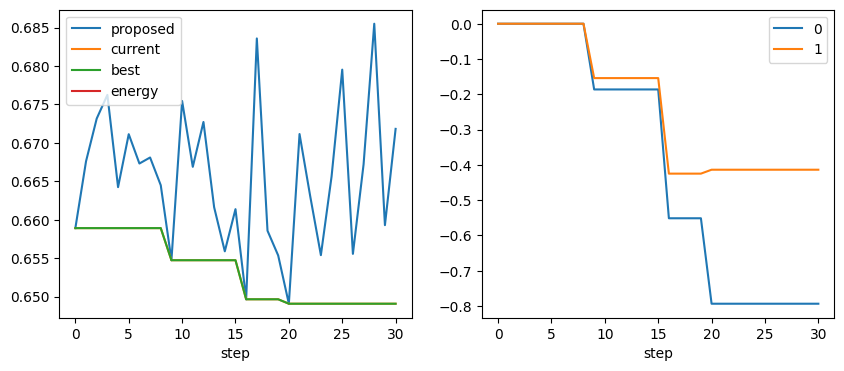

In [52]:
# save_dir = xt.make_dirs_current_time("note/experiments/results")
save_dir = 'note/experiments/results/2025.04.11.081434'

cf = Config("note/experiments/config.yaml")

# rng
rng = XRandomGenerator(0)
np.random.seed(rng.seed)
torch.manual_seed(rng.new_seed())

# validation datasets
tfun = xtarget.PolynominalTargetFunctionGenerator(cf.qml.db.dim_polynomial, seed=rng.new_seed())
tgen = MLDatasetGenerator(tfun, seed=rng.new_seed())

# build policies
policy, reference, optimizer, sampler = prepare_policy(cf)
logger = xsim.Logger()
vlogger = xsim.Logger()
dlogger = xsim.Logger()

# initial logging
# torch.save(policy.state_dict(), xt.join(save_dir, "policy_0000.pth"))

Dqml = tgen.generate(cf.qml.db.size)

model = get_base_qc(cf.nq, cf.qml.db.dim_input, cf.qml.db.dim_output, cf.shots)
weval = xeval.WaveletEvaluator(cf.wavelet, Dqml, wavelet_dim=cf.ocg.dim_wavelet)


tresults = []
for round in range(1, cf.dpo.validation.num_rounds+1):
    # 1. measure the wavelet series
    vresult = weval(model.trainable_parameters, model)

    # 2. estimate the candidate unit
    wseries = vresult.powers
    candidates = [sampler.sample(wseries) for _ in range(2)]
    for candidate in candidates:

        # 3. update the trainable unit
        model.fix_trainable_units()
        model = Model(
            model.nq, model.nc,
            model.input_units,
            model.fixed_units,
            candidate,
        )

        # 4. train the model
        optimizer = xoptim.LocalSearchOptimizer(Dqml)
        tresult = optimizer.optimize(model, cf.qml.num_train, verbose=True)
    tresults.append(tresult)

    # 5. update the model parameters
    model.update_parameters(tresult.first.x)

In [61]:
print([(g._gate.name, int(g.qubit)) for g in sampler.sample(wseries)[0].gates])
print([(g._gate.name, int(g.qubit)) for g in sampler.sample(wseries)[0].gates])

[('rx', 0), ('ry', 1), ('rz', 1)]
[('rz', 1), ('rx', 0), ('rx', 1)]


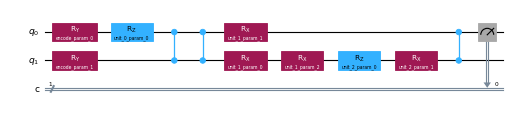

In [53]:
model.draw(plt.gca())
plt.show()